# Our first ubermag simulation

The main goal of this tutorial is to have a quick look at how a simple ubermag simulation inside Jupyter looks like and to make ourselves comfortable with Jupyter. We are going to try to guess what the meaning of Python commands in code cells is, and eventually try to identify the skeleton of ubermag simulation. There are probably going to be many parts you do not understand, but please do not worry - we are going to go into all the details in the next sessions.

## Simple Ubermag simulation

Before we specify and run the simulation, we have to import Ubermag modules we intend to use. For defining micromagnetic models, we need to import `micromagneticmodel` and for defining finite-diference fields, we are going to import `discretisedfield`.

In [1]:
import micromagneticmodel as mm  # mm is just a shorter name we want to use later
import discretisedfield as df  # df is just a shorter name we want to use later
import oommfc as mc
import random

### The main object in Ubermag: System object

The main object in ubermag is `mm.System`. In order to define the micromagnetic system we want to simulate, we have to specify:

1. Energy equation,
2. Dynamics equation (optional),
3. Initial magentisation state configuration.

In [2]:
p1 = (0, 0, 0)
p2 = (100e-9, 100e-9, 84e-9)
region = df.Region(p1=p1, p2=p2)
subregions={}
for i in range(21):
    subregions['r'+str(i)]= df.Region(p1=(0,0,i*4e-9), p2=(100e-9,100e-9,(1+i)*4e-9))
mesh = df.Mesh(region, n=(20, 20, 21), subregions=subregions)

mesh.k3d_subregions()


Output()

In [3]:
system = mm.System(name='Magnetization_Reversal')

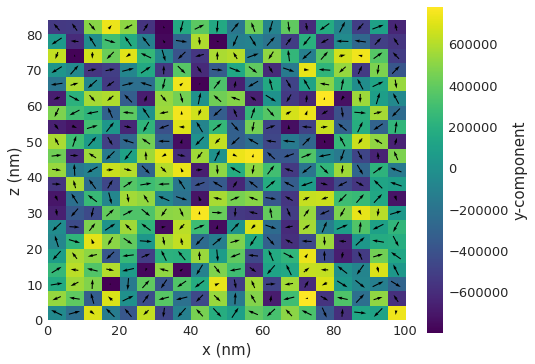

In [4]:
def m_random(point):
    return [2*random.random()-1 for i in range(3)]

system.m = df.Field(mesh, dim=3, value=m_random, norm=8e5)

system.m.plane('y').mpl()

In [9]:
A1 = 5e-12
A2 = -8e-12

Adict = {}
for i in range(21):
    Adict['r'+str(i)]=A1
    if i !=20:
        Adict['r'+str(i)+':'+'r'+str(i+1)]=A2
    else:
        break
        
system.energy = mm.Exchange(A=Adict) + mm.UniaxialAnisotropy(K=6e5, u=(0, 0, 1)) + mm.Demag()

Running OOMMF (ExeOOMMFRunner) [2020/10/20 01:57]... (16.2 s)


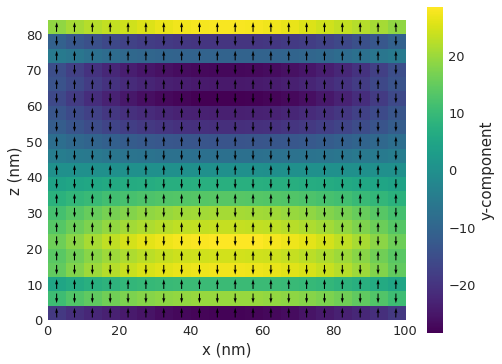

In [10]:
md = mc.MinDriver()
md.drive(system)

system.m.plane('y').mpl()

In [12]:
system.m.orientation.average

(1.68358950821573e-10, 8.691617525446277e-11, 0.04760995348677586)

#### 1. Energy equation

The energy equation for the first Ubermag simulaton is very simple and contains only the following energy terms:

1. Exchange $A=1\,\text{pJ}/\text{m}$,
2. Zeeman $H=(5 \times 10^{6}, 0, 0) \,\text{A/m}$,
3. Demagnetisation.

In [3]:
A = 1e-12  # exchange energy constant (J/m)
H = (5e6, 0, 0)  # external magnetic field in the x-direction (A/m)
system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=H)

#### 2. Dynamics equation

The dynamics equation contains only precession and damping terms:

In [4]:
gamma0 = 2.211e5  # gyrotropic ratio parameter (m/As)
alpha = 0.2  # Gilbert damping
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

#### 3. Initial magnetisation

We choose to simulate a cube with $50 \,\,\text{nm}$ edge length and discretise it into $10$ cells in each direction ($1000$ in total). We initialise the system in positive $y$-direction, i.e. $\mathbf{m} = (0, 1, 0)$, which is different from the equlibrium state we expect for the external magnetic field applied in $x$-direction. For its norm (saturation magnetisation), we choose $M_\text{s} = 8\times 10^{6} \,\text{A}/\text{m}$.

In [5]:
L = 50e-9  # cubic sample edge length (m)
region = df.Region(p1=(0, 0, 0), p2=(L, L, L))
mesh = df.Mesh(region=region, n=(10, 10, 10))

Ms = 8e6  # saturation magnetisation (A/m)
system.m = df.Field(mesh, dim=3, value=(0, 1, 0), norm=Ms)

## Inspecting system object

We have defined the system object and now we can do some inspection to make sure we did not make a mistake. First, we are going to check the energy equation:

In [6]:
system.energy

Exchange(A=1e-12) + Demag() + Zeeman(H=(5000000.0, 0, 0))

This gives us a human-readable equation, which is actually the sum of terms we defined earlier. Similarly, we can check the system's dynamics equation (if we have defined it).

In [7]:
system.dynamics

Precession(gamma0=221100.0) + Damping(alpha=0.2)

Inspecting magnetisation is sligtly more complicated because there are many things we can ask the magnetisation for. Let us have a look at a few basic ones and the rest of them, we are going to explore in later sessions.

The region we defined is:

In [8]:
system.m.mesh.region.k3d()

Output()

Representation of the mesh:

In [9]:
system.m.mesh.k3d()

Output()

A 2d plot of the magnetisation in the z-slice:

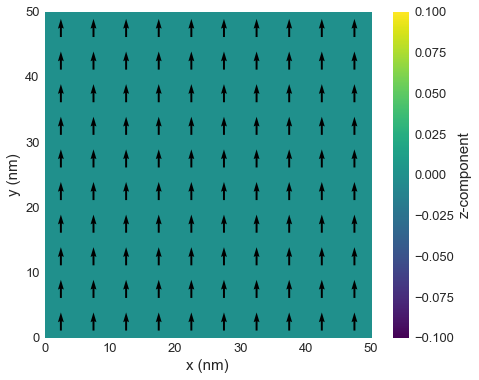

In [10]:
system.m.plane('z').mpl()

Previous plot, but in 3D:

In [11]:
system.m.plane('z').k3d_vector(head_size=10)

Output()

### Driving the system

After the system object is created, we can minimise its energy (relax it) using the Minimisation Driver (`MinDriver`). At this point, we choose the calculator we want to use. During this workshop, we are going to use OOMMF. Therefore, we import OOMMF calculator - `oommfc`.

In [12]:
import oommfc as mc

md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2020/06/18 15:12]... (1.9 s)


The system is now relaxed and its previous magnetisation is now replaced with the new one, and we can plot its slice and compute its average magnetisation.

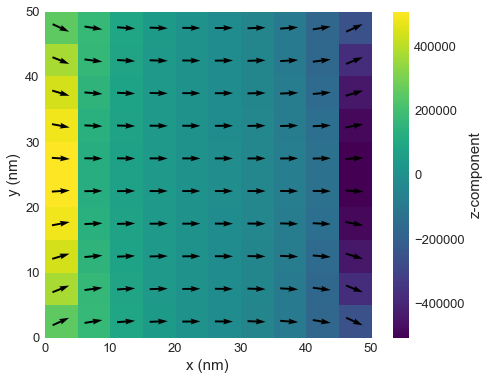

In [13]:
system.m.plane('z', n=(10, 10)).mpl()

In [14]:
system.m.plane('z').k3d_vector(color_field=system.m.z, head_size=20)

Output()

In [15]:
system.m.average

(7860158.23594486, -0.007358911219518632, -4.656612873077393e-12)

In [16]:
system.m.orientation.average

(0.9825197794931033, -9.198639128737973e-10, -4.996003610813204e-19)

We can see that the magnetisation is aligned along the $x$-direction, as expected having in mind we applied the external magnetic field in that direction.